In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 6000) (8569, 1)


,1,2,4,7,10,13,26,31,32,33,...,20104,20105,20108,20109,20115,20118,20121,20122,20123,20124
0,1.024218,0.0,0.0,0.0000,1.302199,0.0,0.0,0.0,0.637877,0.0,...,0.0000,0.0,0.36896,0.0,0.0000,0.0,0.637877,0.0000,0.000000,0.368960
1,0.000000,0.0,0.0,0.0000,1.351171,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.888292,0.0000,0.305824,0.000000
2,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.000000,0.0000,0.000000,0.000000
3,0.000000,0.0,0.0,0.4175,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.4175,0.0,0.00000,0.0,0.4175,0.0,0.937850,0.4175,0.000000,0.000000
4,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.509045,0.0000,0.000000,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scTrainLength = int(len(scDataset) * 0.8)
scValidLength = len(scDataset) - scTrainLength
scTrain, scValid = random_split(scDataset, [scTrainLength, scValidLength])
# print(scValidLength)
scTrainDataLoader = DataLoader(scTrain, shuffle=True, batch_size=args.batch_size,drop_last=True)
scValidDataLoader = DataLoader(scValid, shuffle=True, batch_size=args.batch_size,drop_last=False)

for features, labels in scTrainDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

6000
1714
1714


In [5]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [6]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [7]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [8]:
from preprocessing import transformation
def train(instance_loss,cluster_loss):
    loss_epoch = 0
    for step, (data,label) in enumerate(scTrainDataLoader):
        optimizer.zero_grad()
        
        # x_i=data.clone()
        # x_j=transformation.transformation(x_i).clone()
        # if x_j is not None:
        #     x_j=x_j.to('cuda')
        # else:
        #     x_j=x_i.clone().to('cuda')
        # x_i=x_i.to('cuda')

        x_i=data.clone().to('cuda')
        x_j=data.clone().to('cuda')
        
        z_i,z_j,c_i,c_j=model(x_i,x_j)
        loss_instance=instance_loss(z_i,z_j)
        loss_cluster=cluster_loss(c_i,c_j)
        loss = loss_instance + loss_cluster
        loss.backward()
        optimizer.step()
        if step % 10 == 0:
            print(
                f"Step [{step}/{len(scTrainDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
        loss_epoch += loss.item()
    return loss_epoch


In [9]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [10]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scValidDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [11]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss)
    losses.append(loss_epoch/len(scTrainDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scTrainDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.138285636901855	 loss_cluster: 3.298346519470215

Epoch [0/500]	 Loss: 11.432246843973795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4426 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.112051010131836	 loss_cluster: 3.29799747467041

Epoch [1/500]	 Loss: 11.384344100952148 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4426 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.008941650390625	 loss_cluster: 3.2976629734039307

Epoch [2/500]	 Loss: 11.256099065144857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0034 ARI = 0.0009 F = 0.4426 ACC = 0.0006



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.835224628448486	 loss_cluster: 3.2973203659057617

Epoch [3/500]	 Loss: 11.068250020345053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3041 ARI = 0.1646 F = 0.5109 ACC = 0.0338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.657251358032227	 loss_cluster: 3.2966880798339844

Epoch [4/500]	 Loss: 10.91833241780599 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3905 ARI = 0.2599 F = 0.5530 ACC = 0.0344



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.556729793548584	 loss_cluster: 3.295670747756958

Epoch [5/500]	 Loss: 10.837114016215006 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4134 ARI = 0.2920 F = 0.5604 ACC = 0.0350



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.509462356567383	 loss_cluster: 3.2937498092651367

Epoch [6/500]	 Loss: 10.76270834604899 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2278 ARI = 0.0839 F = 0.3561 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.4212422370910645	 loss_cluster: 3.2906196117401123

Epoch [7/500]	 Loss: 10.676271120707193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2842 ARI = 0.1205 F = 0.3524 ACC = 0.0350



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.344799995422363	 loss_cluster: 3.2836403846740723

Epoch [8/500]	 Loss: 10.604819615681967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3330 ARI = 0.1994 F = 0.3766 ACC = 0.0729



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.277825355529785	 loss_cluster: 3.275817394256592

Epoch [9/500]	 Loss: 10.5361909866333 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3923 ARI = 0.2416 F = 0.4238 ACC = 0.1435



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.22759485244751	 loss_cluster: 3.264773368835449

Epoch [10/500]	 Loss: 10.468593915303549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3930 ARI = 0.2115 F = 0.3949 ACC = 0.1179



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.164942264556885	 loss_cluster: 3.2505855560302734

Epoch [11/500]	 Loss: 10.388299624125162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3999 ARI = 0.2402 F = 0.4152 ACC = 0.0414



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 7.088849067687988	 loss_cluster: 3.2331807613372803

Epoch [12/500]	 Loss: 10.28714402516683 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4464 ARI = 0.3067 F = 0.4639 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.98844051361084	 loss_cluster: 3.2106404304504395

Epoch [13/500]	 Loss: 10.165356953938803 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5127 ARI = 0.3724 F = 0.5053 ACC = 0.0642



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.89402437210083	 loss_cluster: 3.190211057662964

Epoch [14/500]	 Loss: 10.060365358988443 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5411 ARI = 0.3706 F = 0.4987 ACC = 0.4877



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.849254131317139	 loss_cluster: 3.1629862785339355

Epoch [15/500]	 Loss: 9.983382860819498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5479 ARI = 0.3747 F = 0.4986 ACC = 0.4819



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.807161331176758	 loss_cluster: 3.123974084854126

Epoch [16/500]	 Loss: 9.90987777709961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5336 ARI = 0.4222 F = 0.5291 ACC = 0.5642



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.777527332305908	 loss_cluster: 3.085998296737671

Epoch [17/500]	 Loss: 9.839334487915039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5853 ARI = 0.5044 F = 0.5940 ACC = 0.6249



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.754981517791748	 loss_cluster: 3.0455801486968994

Epoch [18/500]	 Loss: 9.77834701538086 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5882 ARI = 0.4809 F = 0.5758 ACC = 0.6132



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.734035491943359	 loss_cluster: 3.0019824504852295

Epoch [19/500]	 Loss: 9.714053471883139 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5913 ARI = 0.4715 F = 0.5676 ACC = 0.5858



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.717054843902588	 loss_cluster: 2.953761339187622

Epoch [20/500]	 Loss: 9.647319793701172 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.6063 ARI = 0.5059 F = 0.5971 ACC = 0.6237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.701971530914307	 loss_cluster: 2.9015581607818604

Epoch [21/500]	 Loss: 9.580009778340658 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5881 ARI = 0.4788 F = 0.5741 ACC = 0.5992



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.689476490020752	 loss_cluster: 2.8441078662872314

Epoch [22/500]	 Loss: 9.507547696431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5940 ARI = 0.4634 F = 0.5622 ACC = 0.6120



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.66716194152832	 loss_cluster: 2.785799264907837

Epoch [23/500]	 Loss: 9.433908462524414 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5619 ARI = 0.3967 F = 0.5072 ACC = 0.5257



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.649311542510986	 loss_cluster: 2.7303049564361572

Epoch [24/500]	 Loss: 9.356523513793945 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5422 ARI = 0.3416 F = 0.4635 ACC = 0.5111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.633592128753662	 loss_cluster: 2.674133539199829

Epoch [25/500]	 Loss: 9.28296152750651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5370 ARI = 0.3438 F = 0.4637 ACC = 0.5443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.607667446136475	 loss_cluster: 2.6271016597747803

Epoch [26/500]	 Loss: 9.221491813659668 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5404 ARI = 0.3270 F = 0.4465 ACC = 0.5064



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.600831508636475	 loss_cluster: 2.5815277099609375

Epoch [27/500]	 Loss: 9.164512634277344 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5358 ARI = 0.3256 F = 0.4409 ACC = 0.4930



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.576075077056885	 loss_cluster: 2.547769546508789

Epoch [28/500]	 Loss: 9.105333964029947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5302 ARI = 0.3254 F = 0.4383 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.571784973144531	 loss_cluster: 2.492814779281616

Epoch [29/500]	 Loss: 9.046844482421875 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5216 ARI = 0.3251 F = 0.4394 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.56658935546875	 loss_cluster: 2.441329002380371

Epoch [30/500]	 Loss: 8.986480077107748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5179 ARI = 0.3289 F = 0.4422 ACC = 0.5047



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.552754878997803	 loss_cluster: 2.392758369445801

Epoch [31/500]	 Loss: 8.92220401763916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5225 ARI = 0.3317 F = 0.4438 ACC = 0.5082



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.544404029846191	 loss_cluster: 2.3424429893493652

Epoch [32/500]	 Loss: 8.877630233764648 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5084 ARI = 0.3041 F = 0.4190 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.531409740447998	 loss_cluster: 2.2991204261779785

Epoch [33/500]	 Loss: 8.820380528767904 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5014 ARI = 0.2977 F = 0.4135 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.5164642333984375	 loss_cluster: 2.2699966430664062

Epoch [34/500]	 Loss: 8.77100912729899 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4905 ARI = 0.2703 F = 0.3892 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.509838104248047	 loss_cluster: 2.220935821533203

Epoch [35/500]	 Loss: 8.720510482788086 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4932 ARI = 0.2699 F = 0.3889 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.509696960449219	 loss_cluster: 2.18266224861145

Epoch [36/500]	 Loss: 8.680486679077148 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4852 ARI = 0.2510 F = 0.3709 ACC = 0.3950



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.502472400665283	 loss_cluster: 2.147146224975586

Epoch [37/500]	 Loss: 8.637221972147623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4812 ARI = 0.2413 F = 0.3613 ACC = 0.3926



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.500006675720215	 loss_cluster: 2.111304759979248

Epoch [38/500]	 Loss: 8.59770933787028 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4774 ARI = 0.2358 F = 0.3560 ACC = 0.3781



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.4902424812316895	 loss_cluster: 2.0643043518066406

Epoch [39/500]	 Loss: 8.551016489664713 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4740 ARI = 0.2272 F = 0.3475 ACC = 0.3670



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.48687219619751	 loss_cluster: 2.032360076904297

Epoch [40/500]	 Loss: 8.510253270467123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4713 ARI = 0.2276 F = 0.3479 ACC = 0.3711



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.4800238609313965	 loss_cluster: 2.001361846923828

Epoch [41/500]	 Loss: 8.472336451212565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4699 ARI = 0.2204 F = 0.3408 ACC = 0.3536



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.470112323760986	 loss_cluster: 1.9687200784683228

Epoch [42/500]	 Loss: 8.428564071655273 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4703 ARI = 0.2185 F = 0.3387 ACC = 0.3448



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.465782642364502	 loss_cluster: 1.9287660121917725

Epoch [43/500]	 Loss: 8.392467180887857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4698 ARI = 0.2186 F = 0.3390 ACC = 0.3582



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.469550132751465	 loss_cluster: 1.8994169235229492

Epoch [44/500]	 Loss: 8.361622174580893 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4688 ARI = 0.2156 F = 0.3360 ACC = 0.3419



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.45552921295166	 loss_cluster: 1.8731892108917236

Epoch [45/500]	 Loss: 8.322311083475748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4655 ARI = 0.2110 F = 0.3315 ACC = 0.3366



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.458926677703857	 loss_cluster: 1.8422478437423706

Epoch [46/500]	 Loss: 8.291908582051596 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4683 ARI = 0.2107 F = 0.3312 ACC = 0.3436



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.45032262802124	 loss_cluster: 1.8204727172851562

Epoch [47/500]	 Loss: 8.260270754496256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4690 ARI = 0.2134 F = 0.3338 ACC = 0.3407



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.442298412322998	 loss_cluster: 1.7961946725845337

Epoch [48/500]	 Loss: 8.233274459838867 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4642 ARI = 0.2079 F = 0.3284 ACC = 0.3378



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.440739154815674	 loss_cluster: 1.7745882272720337

Epoch [49/500]	 Loss: 8.206064860026041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4629 ARI = 0.2106 F = 0.3310 ACC = 0.3407



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.437754154205322	 loss_cluster: 1.7619762420654297

Epoch [50/500]	 Loss: 8.187321980794271 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4653 ARI = 0.2140 F = 0.3344 ACC = 0.3425



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.439340591430664	 loss_cluster: 1.7268261909484863

Epoch [51/500]	 Loss: 8.167662938435873 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4689 ARI = 0.2154 F = 0.3358 ACC = 0.3495



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.427540302276611	 loss_cluster: 1.7131544351577759

Epoch [52/500]	 Loss: 8.140472094217936 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4591 ARI = 0.2084 F = 0.3289 ACC = 0.3331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.422802448272705	 loss_cluster: 1.6995279788970947

Epoch [53/500]	 Loss: 8.120608965555826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4588 ARI = 0.2091 F = 0.3296 ACC = 0.3466



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.428864479064941	 loss_cluster: 1.6778314113616943

Epoch [54/500]	 Loss: 8.106592496236166 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4606 ARI = 0.2153 F = 0.3357 ACC = 0.3530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.422461986541748	 loss_cluster: 1.6752897500991821

Epoch [55/500]	 Loss: 8.094646453857422 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4596 ARI = 0.2120 F = 0.3325 ACC = 0.3477



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.411567211151123	 loss_cluster: 1.6708184480667114

Epoch [56/500]	 Loss: 8.078630129496256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4585 ARI = 0.2117 F = 0.3322 ACC = 0.3506



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.415464401245117	 loss_cluster: 1.6487418413162231

Epoch [57/500]	 Loss: 8.064990361531576 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4609 ARI = 0.2142 F = 0.3347 ACC = 0.3536



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.415055274963379	 loss_cluster: 1.6440002918243408

Epoch [58/500]	 Loss: 8.058220863342285 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4554 ARI = 0.2069 F = 0.3274 ACC = 0.3407



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.401360988616943	 loss_cluster: 1.6506106853485107

Epoch [59/500]	 Loss: 8.051766077677408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4613 ARI = 0.2154 F = 0.3359 ACC = 0.3559



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.41133451461792	 loss_cluster: 1.633429765701294

Epoch [60/500]	 Loss: 8.042781194051107 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4600 ARI = 0.2128 F = 0.3334 ACC = 0.3518



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.397369384765625	 loss_cluster: 1.6267292499542236

Epoch [61/500]	 Loss: 8.025902112325033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4555 ARI = 0.2082 F = 0.3288 ACC = 0.3419



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.406062602996826	 loss_cluster: 1.6176806688308716

Epoch [62/500]	 Loss: 8.026753107706705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4631 ARI = 0.2156 F = 0.3362 ACC = 0.3571



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.393877983093262	 loss_cluster: 1.6180338859558105

Epoch [63/500]	 Loss: 8.008475621541342 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4594 ARI = 0.2110 F = 0.3315 ACC = 0.3501



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.392161846160889	 loss_cluster: 1.6171348094940186

Epoch [64/500]	 Loss: 8.005949974060059 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4584 ARI = 0.2092 F = 0.3298 ACC = 0.3419



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.383903980255127	 loss_cluster: 1.6184769868850708

Epoch [65/500]	 Loss: 7.998434225718181 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4534 ARI = 0.2048 F = 0.3254 ACC = 0.3390



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.381115913391113	 loss_cluster: 1.6092579364776611

Epoch [66/500]	 Loss: 7.990001678466797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4561 ARI = 0.2091 F = 0.3297 ACC = 0.3477



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.3786702156066895	 loss_cluster: 1.6128419637680054

Epoch [67/500]	 Loss: 7.985882759094238 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4499 ARI = 0.2037 F = 0.3243 ACC = 0.3413



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.37822961807251	 loss_cluster: 1.6064374446868896

Epoch [68/500]	 Loss: 7.9783603350321455 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4508 ARI = 0.2041 F = 0.3247 ACC = 0.3413



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.372365474700928	 loss_cluster: 1.5972954034805298

Epoch [69/500]	 Loss: 7.9704664548238116 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4473 ARI = 0.2012 F = 0.3218 ACC = 0.3384



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.365616321563721	 loss_cluster: 1.6074802875518799

Epoch [70/500]	 Loss: 7.967050711313884 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4466 ARI = 0.1989 F = 0.3195 ACC = 0.3331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.363743305206299	 loss_cluster: 1.6049607992172241

Epoch [71/500]	 Loss: 7.965998649597168 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4451 ARI = 0.1991 F = 0.3197 ACC = 0.3361



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.363248825073242	 loss_cluster: 1.593764305114746

Epoch [72/500]	 Loss: 7.954272905985515 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4461 ARI = 0.1983 F = 0.3188 ACC = 0.3384



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.358094215393066	 loss_cluster: 1.5985146760940552

Epoch [73/500]	 Loss: 7.957623640696208 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4410 ARI = 0.1958 F = 0.3164 ACC = 0.3372



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.356331825256348	 loss_cluster: 1.590894341468811

Epoch [74/500]	 Loss: 7.946243127187093 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4413 ARI = 0.1944 F = 0.3149 ACC = 0.3337



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.355705738067627	 loss_cluster: 1.5855580568313599

Epoch [75/500]	 Loss: 7.941686789194743 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4435 ARI = 0.1966 F = 0.3172 ACC = 0.3314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.35482120513916	 loss_cluster: 1.5848770141601562

Epoch [76/500]	 Loss: 7.9386887550354 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4441 ARI = 0.1956 F = 0.3162 ACC = 0.3296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.348219394683838	 loss_cluster: 1.5877286195755005

Epoch [77/500]	 Loss: 7.93522850672404 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4363 ARI = 0.1909 F = 0.3114 ACC = 0.3279



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.353872299194336	 loss_cluster: 1.5808370113372803

Epoch [78/500]	 Loss: 7.9326713879903155 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4373 ARI = 0.1930 F = 0.3135 ACC = 0.3326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.352901935577393	 loss_cluster: 1.5741318464279175

Epoch [79/500]	 Loss: 7.927002906799316 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4357 ARI = 0.1905 F = 0.3110 ACC = 0.3285



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.3468217849731445	 loss_cluster: 1.5791929960250854

Epoch [80/500]	 Loss: 7.923372904459636 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4329 ARI = 0.1872 F = 0.3077 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.33627462387085	 loss_cluster: 1.5849395990371704

Epoch [81/500]	 Loss: 7.920345624287923 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4347 ARI = 0.1894 F = 0.3098 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.343567371368408	 loss_cluster: 1.5746856927871704

Epoch [82/500]	 Loss: 7.919174830118815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4354 ARI = 0.1887 F = 0.3092 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.341717720031738	 loss_cluster: 1.5771714448928833

Epoch [83/500]	 Loss: 7.91825517018636 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4330 ARI = 0.1866 F = 0.3071 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.337597370147705	 loss_cluster: 1.5729737281799316

Epoch [84/500]	 Loss: 7.908551375071208 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4326 ARI = 0.1860 F = 0.3065 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.3351731300354	 loss_cluster: 1.5768705606460571

Epoch [85/500]	 Loss: 7.906789143880208 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4373 ARI = 0.1915 F = 0.3120 ACC = 0.3302



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.339439392089844	 loss_cluster: 1.5746115446090698

Epoch [86/500]	 Loss: 7.909486770629883 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4357 ARI = 0.1880 F = 0.3085 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.327723503112793	 loss_cluster: 1.5731747150421143

Epoch [87/500]	 Loss: 7.908482074737549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4324 ARI = 0.1851 F = 0.3056 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.332561016082764	 loss_cluster: 1.5668929815292358

Epoch [88/500]	 Loss: 7.899201075236003 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4339 ARI = 0.1847 F = 0.3051 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.336885452270508	 loss_cluster: 1.560570478439331

Epoch [89/500]	 Loss: 7.898544947306315 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4324 ARI = 0.1860 F = 0.3065 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.329968452453613	 loss_cluster: 1.5596520900726318

Epoch [90/500]	 Loss: 7.896742343902588 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4332 ARI = 0.1864 F = 0.3069 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.329960346221924	 loss_cluster: 1.5673073530197144

Epoch [91/500]	 Loss: 7.892976442972819 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4347 ARI = 0.1892 F = 0.3096 ACC = 0.3250



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.330598831176758	 loss_cluster: 1.5641905069351196

Epoch [92/500]	 Loss: 7.8899186452229815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4317 ARI = 0.1839 F = 0.3043 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.3261308670043945	 loss_cluster: 1.563544511795044

Epoch [93/500]	 Loss: 7.889295895894368 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4339 ARI = 0.1881 F = 0.3086 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.327678203582764	 loss_cluster: 1.5595089197158813

Epoch [94/500]	 Loss: 7.88738997777303 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4350 ARI = 0.1894 F = 0.3099 ACC = 0.3279



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.326725959777832	 loss_cluster: 1.5618765354156494

Epoch [95/500]	 Loss: 7.890155792236328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4329 ARI = 0.1854 F = 0.3059 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.331743240356445	 loss_cluster: 1.558559775352478

Epoch [96/500]	 Loss: 7.888213316599528 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4364 ARI = 0.1882 F = 0.3087 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.33334493637085	 loss_cluster: 1.5543739795684814

Epoch [97/500]	 Loss: 7.888050715128581 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4325 ARI = 0.1863 F = 0.3067 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.327287673950195	 loss_cluster: 1.5593003034591675

Epoch [98/500]	 Loss: 7.887120087941487 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4335 ARI = 0.1867 F = 0.3072 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.32258939743042	 loss_cluster: 1.5579040050506592

Epoch [99/500]	 Loss: 7.883330186208089 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4323 ARI = 0.1863 F = 0.3068 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.314828872680664	 loss_cluster: 1.5608015060424805

Epoch [100/500]	 Loss: 7.8729783693949384 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4340 ARI = 0.1837 F = 0.3041 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.322741508483887	 loss_cluster: 1.5570316314697266

Epoch [101/500]	 Loss: 7.876311620076497 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4357 ARI = 0.1863 F = 0.3068 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.3139214515686035	 loss_cluster: 1.5538612604141235

Epoch [102/500]	 Loss: 7.870003382364909 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4350 ARI = 0.1859 F = 0.3063 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.318746089935303	 loss_cluster: 1.5541877746582031

Epoch [103/500]	 Loss: 7.871018250783284 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4352 ARI = 0.1864 F = 0.3069 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.312745094299316	 loss_cluster: 1.5534694194793701

Epoch [104/500]	 Loss: 7.869408130645752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4343 ARI = 0.1848 F = 0.3053 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.318676948547363	 loss_cluster: 1.5539568662643433

Epoch [105/500]	 Loss: 7.8680369059244795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4323 ARI = 0.1836 F = 0.3041 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.314698219299316	 loss_cluster: 1.5557267665863037

Epoch [106/500]	 Loss: 7.866063753763835 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4302 ARI = 0.1818 F = 0.3022 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.30873441696167	 loss_cluster: 1.5534154176712036

Epoch [107/500]	 Loss: 7.861128012339274 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4323 ARI = 0.1843 F = 0.3048 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.3082661628723145	 loss_cluster: 1.552242636680603

Epoch [108/500]	 Loss: 7.862496852874756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4349 ARI = 0.1852 F = 0.3056 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.307661056518555	 loss_cluster: 1.5554659366607666

Epoch [109/500]	 Loss: 7.862904071807861 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4337 ARI = 0.1855 F = 0.3059 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.309055328369141	 loss_cluster: 1.5537258386611938

Epoch [110/500]	 Loss: 7.863826910654704 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4328 ARI = 0.1845 F = 0.3049 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.310078144073486	 loss_cluster: 1.5568674802780151

Epoch [111/500]	 Loss: 7.863633473714192 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4347 ARI = 0.1828 F = 0.3032 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.311000823974609	 loss_cluster: 1.550519347190857

Epoch [112/500]	 Loss: 7.860096613566081 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4336 ARI = 0.1834 F = 0.3039 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.306433200836182	 loss_cluster: 1.550440788269043

Epoch [113/500]	 Loss: 7.854548613230388 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4327 ARI = 0.1842 F = 0.3046 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.304862022399902	 loss_cluster: 1.5456150770187378

Epoch [114/500]	 Loss: 7.851587454477946 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4313 ARI = 0.1840 F = 0.3044 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.307204246520996	 loss_cluster: 1.5448116064071655

Epoch [115/500]	 Loss: 7.851974646250407 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.1809 F = 0.3013 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.301540374755859	 loss_cluster: 1.5454622507095337

Epoch [116/500]	 Loss: 7.849829037984212 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4312 ARI = 0.1803 F = 0.3007 ACC = 0.3075



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.300961017608643	 loss_cluster: 1.5501881837844849

Epoch [117/500]	 Loss: 7.852203845977783 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4340 ARI = 0.1858 F = 0.3062 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.30109167098999	 loss_cluster: 1.5527011156082153

Epoch [118/500]	 Loss: 7.854167779286702 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4353 ARI = 0.1882 F = 0.3087 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2987565994262695	 loss_cluster: 1.547028660774231

Epoch [119/500]	 Loss: 7.847139676411946 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4327 ARI = 0.1855 F = 0.3060 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.301189422607422	 loss_cluster: 1.5475270748138428

Epoch [120/500]	 Loss: 7.848945617675781 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4289 ARI = 0.1805 F = 0.3009 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.300342559814453	 loss_cluster: 1.5465800762176514

Epoch [121/500]	 Loss: 7.846237341562907 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4298 ARI = 0.1816 F = 0.3020 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.301234722137451	 loss_cluster: 1.543968677520752

Epoch [122/500]	 Loss: 7.847447872161865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4316 ARI = 0.1818 F = 0.3022 ACC = 0.3104



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.300380706787109	 loss_cluster: 1.5453993082046509

Epoch [123/500]	 Loss: 7.8455244700113935 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.1806 F = 0.3010 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.298709869384766	 loss_cluster: 1.5441962480545044

Epoch [124/500]	 Loss: 7.842597484588623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4297 ARI = 0.1808 F = 0.3012 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.297111988067627	 loss_cluster: 1.5447635650634766

Epoch [125/500]	 Loss: 7.840580145517985 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.1807 F = 0.3012 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.29545783996582	 loss_cluster: 1.5423649549484253

Epoch [126/500]	 Loss: 7.838866551717122 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4315 ARI = 0.1838 F = 0.3043 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.29689884185791	 loss_cluster: 1.5414289236068726

Epoch [127/500]	 Loss: 7.837996482849121 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4321 ARI = 0.1825 F = 0.3029 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.304952621459961	 loss_cluster: 1.542967438697815

Epoch [128/500]	 Loss: 7.84654442469279 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4306 ARI = 0.1807 F = 0.3011 ACC = 0.3075



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.300087928771973	 loss_cluster: 1.5439270734786987

Epoch [129/500]	 Loss: 7.843135039011638 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4310 ARI = 0.1826 F = 0.3031 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2985053062438965	 loss_cluster: 1.5445054769515991

Epoch [130/500]	 Loss: 7.839791615804036 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4326 ARI = 0.1849 F = 0.3054 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.294074058532715	 loss_cluster: 1.54937744140625

Epoch [131/500]	 Loss: 7.839876015981038 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4301 ARI = 0.1825 F = 0.3029 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.291447162628174	 loss_cluster: 1.5435017347335815

Epoch [132/500]	 Loss: 7.83787743250529 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4285 ARI = 0.1812 F = 0.3016 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.295750141143799	 loss_cluster: 1.5394881963729858

Epoch [133/500]	 Loss: 7.834619045257568 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.1826 F = 0.3030 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.295036315917969	 loss_cluster: 1.5422983169555664

Epoch [134/500]	 Loss: 7.836106459299724 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4314 ARI = 0.1843 F = 0.3047 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.294558048248291	 loss_cluster: 1.540010690689087

Epoch [135/500]	 Loss: 7.837468942006429 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4304 ARI = 0.1835 F = 0.3039 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.294243812561035	 loss_cluster: 1.54850172996521

Epoch [136/500]	 Loss: 7.839312394460042 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4280 ARI = 0.1797 F = 0.3001 ACC = 0.3086



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.300549030303955	 loss_cluster: 1.5384080410003662

Epoch [137/500]	 Loss: 7.839850266774495 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4277 ARI = 0.1798 F = 0.3002 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.290260314941406	 loss_cluster: 1.541393518447876

Epoch [138/500]	 Loss: 7.8323737780253095 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4282 ARI = 0.1802 F = 0.3006 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2915191650390625	 loss_cluster: 1.5396101474761963

Epoch [139/500]	 Loss: 7.833264509836833 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4292 ARI = 0.1818 F = 0.3022 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.287966251373291	 loss_cluster: 1.540191888809204

Epoch [140/500]	 Loss: 7.829489390055339 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4291 ARI = 0.1809 F = 0.3013 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2956719398498535	 loss_cluster: 1.5399892330169678

Epoch [141/500]	 Loss: 7.832327683766683 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4292 ARI = 0.1806 F = 0.3010 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.289149284362793	 loss_cluster: 1.5403907299041748

Epoch [142/500]	 Loss: 7.830075740814209 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4292 ARI = 0.1832 F = 0.3036 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.289409637451172	 loss_cluster: 1.5423134565353394

Epoch [143/500]	 Loss: 7.828769048055013 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4291 ARI = 0.1845 F = 0.3050 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.286799907684326	 loss_cluster: 1.5451472997665405

Epoch [144/500]	 Loss: 7.827332337697347 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4321 ARI = 0.1854 F = 0.3059 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.291979789733887	 loss_cluster: 1.5396599769592285

Epoch [145/500]	 Loss: 7.826256116231282 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4286 ARI = 0.1833 F = 0.3037 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.288854122161865	 loss_cluster: 1.5346566438674927

Epoch [146/500]	 Loss: 7.827833493550618 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4283 ARI = 0.1815 F = 0.3019 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.290351867675781	 loss_cluster: 1.5398327112197876

Epoch [147/500]	 Loss: 7.825109958648682 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4284 ARI = 0.1814 F = 0.3019 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.287229537963867	 loss_cluster: 1.5445477962493896

Epoch [148/500]	 Loss: 7.828671455383301 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.1798 F = 0.3002 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.285593509674072	 loss_cluster: 1.5356013774871826

Epoch [149/500]	 Loss: 7.822730541229248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4291 ARI = 0.1822 F = 0.3026 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2901387214660645	 loss_cluster: 1.5348843336105347

Epoch [150/500]	 Loss: 7.823465506235759 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4304 ARI = 0.1835 F = 0.3040 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.296755790710449	 loss_cluster: 1.5339792966842651

Epoch [151/500]	 Loss: 7.8277614911397295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4287 ARI = 0.1834 F = 0.3038 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.289278984069824	 loss_cluster: 1.536116361618042

Epoch [152/500]	 Loss: 7.821711381276448 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4276 ARI = 0.1805 F = 0.3009 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.288519382476807	 loss_cluster: 1.5402573347091675

Epoch [153/500]	 Loss: 7.827034155527751 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1803 F = 0.3007 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.285849094390869	 loss_cluster: 1.5329257249832153

Epoch [154/500]	 Loss: 7.82170565923055 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4281 ARI = 0.1821 F = 0.3025 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2885847091674805	 loss_cluster: 1.5335782766342163

Epoch [155/500]	 Loss: 7.818467458089192 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4280 ARI = 0.1817 F = 0.3021 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.287460803985596	 loss_cluster: 1.5350524187088013

Epoch [156/500]	 Loss: 7.819622039794922 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.1820 F = 0.3024 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.284421443939209	 loss_cluster: 1.5351951122283936

Epoch [157/500]	 Loss: 7.827381769816081 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4296 ARI = 0.1824 F = 0.3028 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.281610012054443	 loss_cluster: 1.5318942070007324

Epoch [158/500]	 Loss: 7.823359648386638 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4293 ARI = 0.1818 F = 0.3022 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.284307956695557	 loss_cluster: 1.5346442461013794

Epoch [159/500]	 Loss: 7.81734561920166 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4281 ARI = 0.1797 F = 0.3001 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.283024311065674	 loss_cluster: 1.5303720235824585

Epoch [160/500]	 Loss: 7.815817038218181 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.1790 F = 0.2993 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.285021781921387	 loss_cluster: 1.53471839427948

Epoch [161/500]	 Loss: 7.8160780270894366 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.1799 F = 0.3003 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.284868240356445	 loss_cluster: 1.5362402200698853

Epoch [162/500]	 Loss: 7.815281232198079 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4277 ARI = 0.1814 F = 0.3018 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.279682636260986	 loss_cluster: 1.5322240591049194

Epoch [163/500]	 Loss: 7.819431304931641 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4290 ARI = 0.1814 F = 0.3018 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.279792785644531	 loss_cluster: 1.5338575839996338

Epoch [164/500]	 Loss: 7.816769123077393 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4293 ARI = 0.1809 F = 0.3013 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2844743728637695	 loss_cluster: 1.5377161502838135

Epoch [165/500]	 Loss: 7.8223849932352705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4288 ARI = 0.1802 F = 0.3006 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.291523456573486	 loss_cluster: 1.5288236141204834

Epoch [166/500]	 Loss: 7.815762360890706 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4266 ARI = 0.1796 F = 0.3000 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.280813694000244	 loss_cluster: 1.5331612825393677

Epoch [167/500]	 Loss: 7.8109660148620605 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4270 ARI = 0.1811 F = 0.3015 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.279990196228027	 loss_cluster: 1.537333369255066

Epoch [168/500]	 Loss: 7.810348192850749 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4279 ARI = 0.1812 F = 0.3016 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.275636196136475	 loss_cluster: 1.5344576835632324

Epoch [169/500]	 Loss: 7.8075822194417315 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4278 ARI = 0.1809 F = 0.3013 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.273894309997559	 loss_cluster: 1.534059762954712

Epoch [170/500]	 Loss: 7.806914170583089 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4276 ARI = 0.1803 F = 0.3007 ACC = 0.3092



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.274700164794922	 loss_cluster: 1.536421537399292

Epoch [171/500]	 Loss: 7.806768417358398 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4287 ARI = 0.1811 F = 0.3016 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.273888111114502	 loss_cluster: 1.5325790643692017

Epoch [172/500]	 Loss: 7.808653195699056 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.1793 F = 0.2997 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.273871898651123	 loss_cluster: 1.5267328023910522

Epoch [173/500]	 Loss: 7.804055690765381 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.1800 F = 0.3004 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.275638103485107	 loss_cluster: 1.5313597917556763

Epoch [174/500]	 Loss: 7.807705084482829 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1798 F = 0.3002 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.273177623748779	 loss_cluster: 1.5328642129898071

Epoch [175/500]	 Loss: 7.809105555216472 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4272 ARI = 0.1808 F = 0.3012 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.272150993347168	 loss_cluster: 1.5308964252471924

Epoch [176/500]	 Loss: 7.807485103607178 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4278 ARI = 0.1810 F = 0.3014 ACC = 0.3110



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.275989055633545	 loss_cluster: 1.5329285860061646

Epoch [177/500]	 Loss: 7.807507514953613 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.1796 F = 0.3000 ACC = 0.3110



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.276237964630127	 loss_cluster: 1.5321277379989624

Epoch [178/500]	 Loss: 7.805553277333577 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1794 F = 0.2998 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.271869659423828	 loss_cluster: 1.5387804508209229

Epoch [179/500]	 Loss: 7.809263706207275 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4231 ARI = 0.1770 F = 0.2974 ACC = 0.3092



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.27042293548584	 loss_cluster: 1.5325769186019897

Epoch [180/500]	 Loss: 7.80247147878011 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1777 F = 0.2981 ACC = 0.3098



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.274158477783203	 loss_cluster: 1.5309817790985107

Epoch [181/500]	 Loss: 7.804215431213379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1792 F = 0.2996 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.271409034729004	 loss_cluster: 1.5316202640533447

Epoch [182/500]	 Loss: 7.803363800048828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4284 ARI = 0.1820 F = 0.3024 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2801008224487305	 loss_cluster: 1.5290966033935547

Epoch [183/500]	 Loss: 7.810140609741211 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.1776 F = 0.2979 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.279269218444824	 loss_cluster: 1.5259239673614502

Epoch [184/500]	 Loss: 7.806954065958659 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1781 F = 0.2985 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.27957820892334	 loss_cluster: 1.5357630252838135

Epoch [185/500]	 Loss: 7.808038552602132 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1796 F = 0.3000 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.27431058883667	 loss_cluster: 1.5308301448822021

Epoch [186/500]	 Loss: 7.8097764650980634 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4254 ARI = 0.1795 F = 0.2998 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.275943756103516	 loss_cluster: 1.526047706604004

Epoch [187/500]	 Loss: 7.801502704620361 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1797 F = 0.3001 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.269657135009766	 loss_cluster: 1.5272908210754395

Epoch [188/500]	 Loss: 7.798393726348877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4270 ARI = 0.1806 F = 0.3010 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2694830894470215	 loss_cluster: 1.5295722484588623

Epoch [189/500]	 Loss: 7.798096974690755 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1789 F = 0.2993 ACC = 0.3104



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.265377998352051	 loss_cluster: 1.5257972478866577

Epoch [190/500]	 Loss: 7.796276251475017 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.1782 F = 0.2985 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.268953800201416	 loss_cluster: 1.5274230241775513

Epoch [191/500]	 Loss: 7.800753911336263 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1806 F = 0.3010 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.26993465423584	 loss_cluster: 1.5306260585784912

Epoch [192/500]	 Loss: 7.7980631192525225 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4263 ARI = 0.1812 F = 0.3016 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.268882751464844	 loss_cluster: 1.5312273502349854

Epoch [193/500]	 Loss: 7.800713221232097 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1784 F = 0.2988 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.272017002105713	 loss_cluster: 1.5244649648666382

Epoch [194/500]	 Loss: 7.796701113382976 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1792 F = 0.2996 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.271030902862549	 loss_cluster: 1.529160737991333

Epoch [195/500]	 Loss: 7.798329671223958 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1796 F = 0.3000 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2692437171936035	 loss_cluster: 1.5307778120040894

Epoch [196/500]	 Loss: 7.798360029856364 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.1802 F = 0.3006 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.270045757293701	 loss_cluster: 1.5281614065170288

Epoch [197/500]	 Loss: 7.7961381276448565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4261 ARI = 0.1794 F = 0.2998 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.276281356811523	 loss_cluster: 1.534441351890564

Epoch [198/500]	 Loss: 7.802720864613851 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1794 F = 0.2997 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.281166076660156	 loss_cluster: 1.525887131690979

Epoch [199/500]	 Loss: 7.802714506785075 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1787 F = 0.2991 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.273247718811035	 loss_cluster: 1.5303916931152344

Epoch [200/500]	 Loss: 7.7996493975321455 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1799 F = 0.3003 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.270977973937988	 loss_cluster: 1.526310682296753

Epoch [201/500]	 Loss: 7.794993082682292 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1796 F = 0.3000 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.268109321594238	 loss_cluster: 1.5280853509902954

Epoch [202/500]	 Loss: 7.796650250752767 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1797 F = 0.3001 ACC = 0.3110



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.268463134765625	 loss_cluster: 1.5268268585205078

Epoch [203/500]	 Loss: 7.7964582443237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1797 F = 0.3001 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.267367362976074	 loss_cluster: 1.5277698040008545

Epoch [204/500]	 Loss: 7.795208930969238 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1799 F = 0.3003 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.272574424743652	 loss_cluster: 1.5258392095565796

Epoch [205/500]	 Loss: 7.79716952641805 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1776 F = 0.2980 ACC = 0.3110



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2674174308776855	 loss_cluster: 1.526435375213623

Epoch [206/500]	 Loss: 7.795425256093343 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1784 F = 0.2988 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.265880107879639	 loss_cluster: 1.5268313884735107

Epoch [207/500]	 Loss: 7.791748682657878 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.1782 F = 0.2985 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.262876987457275	 loss_cluster: 1.526755690574646

Epoch [208/500]	 Loss: 7.790437380472819 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1793 F = 0.2997 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.265831470489502	 loss_cluster: 1.5294303894042969

Epoch [209/500]	 Loss: 7.793307781219482 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1789 F = 0.2993 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.263801097869873	 loss_cluster: 1.5250542163848877

Epoch [210/500]	 Loss: 7.791975975036621 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1799 F = 0.3003 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.263400077819824	 loss_cluster: 1.526904821395874

Epoch [211/500]	 Loss: 7.790370941162109 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4227 ARI = 0.1781 F = 0.2984 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.26516056060791	 loss_cluster: 1.5226258039474487

Epoch [212/500]	 Loss: 7.7913665771484375 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4217 ARI = 0.1788 F = 0.2992 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2665510177612305	 loss_cluster: 1.526564121246338

Epoch [213/500]	 Loss: 7.791177431742351 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4218 ARI = 0.1772 F = 0.2976 ACC = 0.3086



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.262243747711182	 loss_cluster: 1.5230897665023804

Epoch [214/500]	 Loss: 7.790564854939778 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4218 ARI = 0.1772 F = 0.2975 ACC = 0.3098



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.26282262802124	 loss_cluster: 1.5256751775741577

Epoch [215/500]	 Loss: 7.791418393452962 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1786 F = 0.2990 ACC = 0.3081



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.266288757324219	 loss_cluster: 1.525054693222046

Epoch [216/500]	 Loss: 7.791129430135091 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4231 ARI = 0.1771 F = 0.2975 ACC = 0.3098



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.260725498199463	 loss_cluster: 1.5267943143844604

Epoch [217/500]	 Loss: 7.786961396535237 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1792 F = 0.2996 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.266188144683838	 loss_cluster: 1.5257222652435303

Epoch [218/500]	 Loss: 7.78894058863322 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.1803 F = 0.3007 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.263425827026367	 loss_cluster: 1.5258018970489502

Epoch [219/500]	 Loss: 7.787302017211914 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1788 F = 0.2992 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.264069080352783	 loss_cluster: 1.5224908590316772

Epoch [220/500]	 Loss: 7.7869307200113935 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1791 F = 0.2995 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.261183738708496	 loss_cluster: 1.5218405723571777

Epoch [221/500]	 Loss: 7.786617120107015 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1787 F = 0.2990 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.265276908874512	 loss_cluster: 1.5228902101516724

Epoch [222/500]	 Loss: 7.7878438631693525 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4230 ARI = 0.1788 F = 0.2992 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2646589279174805	 loss_cluster: 1.5295920372009277

Epoch [223/500]	 Loss: 7.788580735524495 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1797 F = 0.3001 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.261143207550049	 loss_cluster: 1.525136947631836

Epoch [224/500]	 Loss: 7.787102222442627 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1787 F = 0.2991 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.26231575012207	 loss_cluster: 1.5216903686523438

Epoch [225/500]	 Loss: 7.790371735890706 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1778 F = 0.2981 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.259293556213379	 loss_cluster: 1.525441288948059

Epoch [226/500]	 Loss: 7.785353024800618 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1786 F = 0.2990 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.262659549713135	 loss_cluster: 1.5248066186904907

Epoch [227/500]	 Loss: 7.7867255210876465 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.1793 F = 0.2997 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2632293701171875	 loss_cluster: 1.5254342555999756

Epoch [228/500]	 Loss: 7.787384668986003 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4268 ARI = 0.1821 F = 0.3025 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.26490592956543	 loss_cluster: 1.5245956182479858

Epoch [229/500]	 Loss: 7.789746602376302 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.1819 F = 0.3023 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.262241363525391	 loss_cluster: 1.5274840593338013

Epoch [230/500]	 Loss: 7.787318070729573 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1798 F = 0.3002 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.259101867675781	 loss_cluster: 1.5289119482040405

Epoch [231/500]	 Loss: 7.786064147949219 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1792 F = 0.2996 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.259954452514648	 loss_cluster: 1.5274146795272827

Epoch [232/500]	 Loss: 7.785919189453125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4233 ARI = 0.1778 F = 0.2982 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2622528076171875	 loss_cluster: 1.5250874757766724

Epoch [233/500]	 Loss: 7.781961441040039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4212 ARI = 0.1767 F = 0.2971 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.259721279144287	 loss_cluster: 1.5220338106155396

Epoch [234/500]	 Loss: 7.783217430114746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4216 ARI = 0.1772 F = 0.2976 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.258902072906494	 loss_cluster: 1.521680235862732

Epoch [235/500]	 Loss: 7.785184542338054 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1776 F = 0.2980 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.262697696685791	 loss_cluster: 1.527591586112976

Epoch [236/500]	 Loss: 7.786651770273845 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1774 F = 0.2977 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.263980865478516	 loss_cluster: 1.5238091945648193

Epoch [237/500]	 Loss: 7.783812363942464 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1794 F = 0.2998 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.258526802062988	 loss_cluster: 1.525630235671997

Epoch [238/500]	 Loss: 7.780112425486247 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.1804 F = 0.3008 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.258545875549316	 loss_cluster: 1.5227056741714478

Epoch [239/500]	 Loss: 7.780812899271647 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1812 F = 0.3016 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.259909629821777	 loss_cluster: 1.5198131799697876

Epoch [240/500]	 Loss: 7.782172838846843 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4231 ARI = 0.1786 F = 0.2989 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.256716728210449	 loss_cluster: 1.520885705947876

Epoch [241/500]	 Loss: 7.779074350992839 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1781 F = 0.2985 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.256113529205322	 loss_cluster: 1.5255794525146484

Epoch [242/500]	 Loss: 7.782043933868408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1785 F = 0.2989 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2570672035217285	 loss_cluster: 1.5257214307785034

Epoch [243/500]	 Loss: 7.780748208363851 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1812 F = 0.3016 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.253874778747559	 loss_cluster: 1.5284101963043213

Epoch [244/500]	 Loss: 7.782613595326741 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4232 ARI = 0.1790 F = 0.2994 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.254109859466553	 loss_cluster: 1.5226421356201172

Epoch [245/500]	 Loss: 7.78193457921346 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1789 F = 0.2993 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.253479480743408	 loss_cluster: 1.5240528583526611

Epoch [246/500]	 Loss: 7.778757731119792 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4242 ARI = 0.1792 F = 0.2996 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.253346920013428	 loss_cluster: 1.5225821733474731

Epoch [247/500]	 Loss: 7.778149445851644 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4233 ARI = 0.1788 F = 0.2992 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.25377082824707	 loss_cluster: 1.5246970653533936

Epoch [248/500]	 Loss: 7.77960205078125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4219 ARI = 0.1772 F = 0.2975 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.26405668258667	 loss_cluster: 1.5249813795089722

Epoch [249/500]	 Loss: 7.786312580108643 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4228 ARI = 0.1776 F = 0.2980 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.267563343048096	 loss_cluster: 1.524513602256775

Epoch [250/500]	 Loss: 7.78174368540446 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1800 F = 0.3004 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2612528800964355	 loss_cluster: 1.5254380702972412

Epoch [251/500]	 Loss: 7.786508560180664 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1786 F = 0.2990 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2587971687316895	 loss_cluster: 1.52341628074646

Epoch [252/500]	 Loss: 7.789060274759929 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4231 ARI = 0.1773 F = 0.2977 ACC = 0.3110



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.25741720199585	 loss_cluster: 1.5285509824752808

Epoch [253/500]	 Loss: 7.782706419626872 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1792 F = 0.2996 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2596282958984375	 loss_cluster: 1.5215052366256714

Epoch [254/500]	 Loss: 7.783790906270345 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4232 ARI = 0.1782 F = 0.2986 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.261964321136475	 loss_cluster: 1.5229216814041138

Epoch [255/500]	 Loss: 7.783097267150879 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1787 F = 0.2991 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.27097749710083	 loss_cluster: 1.5216885805130005

Epoch [256/500]	 Loss: 7.784436225891113 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1788 F = 0.2991 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.25497579574585	 loss_cluster: 1.5229978561401367

Epoch [257/500]	 Loss: 7.781785170237224 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1800 F = 0.3003 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.255069732666016	 loss_cluster: 1.5228148698806763

Epoch [258/500]	 Loss: 7.77772839864095 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1798 F = 0.3002 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.253333568572998	 loss_cluster: 1.5207525491714478

Epoch [259/500]	 Loss: 7.776167074839274 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4266 ARI = 0.1801 F = 0.3005 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.255776405334473	 loss_cluster: 1.5212092399597168

Epoch [260/500]	 Loss: 7.776080290476481 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4213 ARI = 0.1764 F = 0.2968 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.252203941345215	 loss_cluster: 1.5234689712524414

Epoch [261/500]	 Loss: 7.775526205698649 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1784 F = 0.2988 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250131130218506	 loss_cluster: 1.5268185138702393

Epoch [262/500]	 Loss: 7.779377301534017 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1802 F = 0.3006 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.254563331604004	 loss_cluster: 1.5280802249908447

Epoch [263/500]	 Loss: 7.775414943695068 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1814 F = 0.3018 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.253942012786865	 loss_cluster: 1.5219876766204834

Epoch [264/500]	 Loss: 7.773934364318848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4247 ARI = 0.1795 F = 0.2999 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.252523422241211	 loss_cluster: 1.5231343507766724

Epoch [265/500]	 Loss: 7.776283264160156 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1791 F = 0.2995 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.258853912353516	 loss_cluster: 1.5256626605987549

Epoch [266/500]	 Loss: 7.778626124064128 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1793 F = 0.2997 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2574615478515625	 loss_cluster: 1.5265090465545654

Epoch [267/500]	 Loss: 7.779446919759114 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.1798 F = 0.3002 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.25982666015625	 loss_cluster: 1.5213543176651

Epoch [268/500]	 Loss: 7.77844254175822 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1781 F = 0.2984 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250675678253174	 loss_cluster: 1.5263073444366455

Epoch [269/500]	 Loss: 7.778255939483643 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1787 F = 0.2991 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.249388694763184	 loss_cluster: 1.522306203842163

Epoch [270/500]	 Loss: 7.774195671081543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1798 F = 0.3002 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.25390100479126	 loss_cluster: 1.520551085472107

Epoch [271/500]	 Loss: 7.7742336591084795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1797 F = 0.3001 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.262759208679199	 loss_cluster: 1.5226079225540161

Epoch [272/500]	 Loss: 7.783269882202148 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.1794 F = 0.2998 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.254499912261963	 loss_cluster: 1.5183242559432983

Epoch [273/500]	 Loss: 7.774272759755452 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1797 F = 0.3001 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.251102447509766	 loss_cluster: 1.519456148147583

Epoch [274/500]	 Loss: 7.775073846181233 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1800 F = 0.3004 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250647068023682	 loss_cluster: 1.5234590768814087

Epoch [275/500]	 Loss: 7.777281284332275 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.1806 F = 0.3010 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.251412391662598	 loss_cluster: 1.519610047340393

Epoch [276/500]	 Loss: 7.775375525156657 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1803 F = 0.3007 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250114440917969	 loss_cluster: 1.5204473733901978

Epoch [277/500]	 Loss: 7.7712758382161455 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.1802 F = 0.3006 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.254200458526611	 loss_cluster: 1.5199148654937744

Epoch [278/500]	 Loss: 7.77299149831136 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4275 ARI = 0.1820 F = 0.3024 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.252928733825684	 loss_cluster: 1.526945948600769

Epoch [279/500]	 Loss: 7.775497277577718 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4281 ARI = 0.1814 F = 0.3018 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.251632213592529	 loss_cluster: 1.5196282863616943

Epoch [280/500]	 Loss: 7.7726664543151855 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4280 ARI = 0.1825 F = 0.3029 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2508158683776855	 loss_cluster: 1.5226314067840576

Epoch [281/500]	 Loss: 7.769993940989177 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1802 F = 0.3006 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.249651908874512	 loss_cluster: 1.5204440355300903

Epoch [282/500]	 Loss: 7.769251664479573 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1798 F = 0.3002 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.247963905334473	 loss_cluster: 1.522053837776184

Epoch [283/500]	 Loss: 7.7714619636535645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1811 F = 0.3015 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.249392032623291	 loss_cluster: 1.5203019380569458

Epoch [284/500]	 Loss: 7.770023663838704 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.1802 F = 0.3006 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.251623630523682	 loss_cluster: 1.520033836364746

Epoch [285/500]	 Loss: 7.771441300710042 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1788 F = 0.2992 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.248600959777832	 loss_cluster: 1.5260618925094604

Epoch [286/500]	 Loss: 7.772581418355306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1788 F = 0.2991 ACC = 0.3104



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246527194976807	 loss_cluster: 1.5228803157806396

Epoch [287/500]	 Loss: 7.770358721415202 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1779 F = 0.2983 ACC = 0.3092



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.24700927734375	 loss_cluster: 1.5205332040786743

Epoch [288/500]	 Loss: 7.771601676940918 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.1799 F = 0.3003 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246083736419678	 loss_cluster: 1.5217820405960083

Epoch [289/500]	 Loss: 7.770603020985921 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1795 F = 0.2998 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.245739459991455	 loss_cluster: 1.5181289911270142

Epoch [290/500]	 Loss: 7.77047077814738 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1790 F = 0.2994 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.251890659332275	 loss_cluster: 1.5236281156539917

Epoch [291/500]	 Loss: 7.774036566416423 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1805 F = 0.3009 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.245415687561035	 loss_cluster: 1.523908257484436

Epoch [292/500]	 Loss: 7.7700808842976885 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.1803 F = 0.3007 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.24668025970459	 loss_cluster: 1.5177466869354248

Epoch [293/500]	 Loss: 7.768914540608724 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.1796 F = 0.3000 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2486395835876465	 loss_cluster: 1.5199393033981323

Epoch [294/500]	 Loss: 7.770924091339111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4263 ARI = 0.1803 F = 0.3007 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246106147766113	 loss_cluster: 1.5206056833267212

Epoch [295/500]	 Loss: 7.769492944081624 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4254 ARI = 0.1802 F = 0.3005 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.24830961227417	 loss_cluster: 1.5213854312896729

Epoch [296/500]	 Loss: 7.770678997039795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1807 F = 0.3011 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.248738765716553	 loss_cluster: 1.5207618474960327

Epoch [297/500]	 Loss: 7.772303740183513 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1809 F = 0.3013 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.252575397491455	 loss_cluster: 1.5229617357254028

Epoch [298/500]	 Loss: 7.7698845863342285 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1813 F = 0.3017 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.255855560302734	 loss_cluster: 1.5206859111785889

Epoch [299/500]	 Loss: 7.7740888595581055 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1817 F = 0.3021 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250080585479736	 loss_cluster: 1.52329421043396

Epoch [300/500]	 Loss: 7.771285692850749 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1812 F = 0.3016 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250972747802734	 loss_cluster: 1.5189043283462524

Epoch [301/500]	 Loss: 7.771049499511719 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.1816 F = 0.3020 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.247424125671387	 loss_cluster: 1.520905613899231

Epoch [302/500]	 Loss: 7.767199357350667 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1798 F = 0.3002 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.243921756744385	 loss_cluster: 1.5189400911331177

Epoch [303/500]	 Loss: 7.767103672027588 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.1787 F = 0.2991 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.242400169372559	 loss_cluster: 1.5199013948440552

Epoch [304/500]	 Loss: 7.76977523167928 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1787 F = 0.2991 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.249423503875732	 loss_cluster: 1.5181111097335815

Epoch [305/500]	 Loss: 7.767869631449382 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.1800 F = 0.3004 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.24507474899292	 loss_cluster: 1.5222781896591187

Epoch [306/500]	 Loss: 7.766279856363933 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.1798 F = 0.3002 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250885486602783	 loss_cluster: 1.5201455354690552

Epoch [307/500]	 Loss: 7.769916534423828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1801 F = 0.3005 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246060371398926	 loss_cluster: 1.5208728313446045

Epoch [308/500]	 Loss: 7.767488320668538 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1802 F = 0.3006 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2462310791015625	 loss_cluster: 1.5210447311401367

Epoch [309/500]	 Loss: 7.765597502390544 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1803 F = 0.3007 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.249814510345459	 loss_cluster: 1.5232049226760864

Epoch [310/500]	 Loss: 7.768038908640544 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4254 ARI = 0.1811 F = 0.3015 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2431745529174805	 loss_cluster: 1.5249418020248413

Epoch [311/500]	 Loss: 7.768334865570068 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1815 F = 0.3019 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2443013191223145	 loss_cluster: 1.5182946920394897

Epoch [312/500]	 Loss: 7.765415668487549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1803 F = 0.3007 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.244810104370117	 loss_cluster: 1.521828293800354

Epoch [313/500]	 Loss: 7.767022291819255 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1804 F = 0.3007 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.245932102203369	 loss_cluster: 1.519067406654358

Epoch [314/500]	 Loss: 7.767563343048096 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1812 F = 0.3017 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.244784355163574	 loss_cluster: 1.516183614730835

Epoch [315/500]	 Loss: 7.768438339233398 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1801 F = 0.3005 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.244210243225098	 loss_cluster: 1.5208005905151367

Epoch [316/500]	 Loss: 7.770971298217773 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1804 F = 0.3008 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.247777462005615	 loss_cluster: 1.51810622215271

Epoch [317/500]	 Loss: 7.769031365712483 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1792 F = 0.2996 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.251031398773193	 loss_cluster: 1.5184881687164307

Epoch [318/500]	 Loss: 7.772385438283284 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1790 F = 0.2994 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.248201370239258	 loss_cluster: 1.5220396518707275

Epoch [319/500]	 Loss: 7.766056537628174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.1788 F = 0.2991 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.242245197296143	 loss_cluster: 1.5166409015655518

Epoch [320/500]	 Loss: 7.761893272399902 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1788 F = 0.2991 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2433342933654785	 loss_cluster: 1.5215312242507935

Epoch [321/500]	 Loss: 7.764217853546143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1812 F = 0.3016 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.244319438934326	 loss_cluster: 1.5228010416030884

Epoch [322/500]	 Loss: 7.765282154083252 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1804 F = 0.3008 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.242290019989014	 loss_cluster: 1.5213855504989624

Epoch [323/500]	 Loss: 7.762759208679199 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4261 ARI = 0.1807 F = 0.3011 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246167182922363	 loss_cluster: 1.5229543447494507

Epoch [324/500]	 Loss: 7.765215873718262 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.1815 F = 0.3019 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.240058422088623	 loss_cluster: 1.5208523273468018

Epoch [325/500]	 Loss: 7.760520140329997 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4263 ARI = 0.1811 F = 0.3015 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.242188930511475	 loss_cluster: 1.5221004486083984

Epoch [326/500]	 Loss: 7.7647013664245605 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4261 ARI = 0.1805 F = 0.3009 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.24747896194458	 loss_cluster: 1.5194586515426636

Epoch [327/500]	 Loss: 7.763474623362224 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1810 F = 0.3014 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.242258071899414	 loss_cluster: 1.5202394723892212

Epoch [328/500]	 Loss: 7.76516596476237 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1806 F = 0.3010 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.245302200317383	 loss_cluster: 1.520463228225708

Epoch [329/500]	 Loss: 7.764871279398601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1807 F = 0.3011 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.245151042938232	 loss_cluster: 1.5222320556640625

Epoch [330/500]	 Loss: 7.767384688059489 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.1807 F = 0.3011 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.243952751159668	 loss_cluster: 1.522601842880249

Epoch [331/500]	 Loss: 7.770020484924316 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4263 ARI = 0.1805 F = 0.3009 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246052265167236	 loss_cluster: 1.5258402824401855

Epoch [332/500]	 Loss: 7.772940317789714 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1817 F = 0.3021 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2396440505981445	 loss_cluster: 1.5214335918426514

Epoch [333/500]	 Loss: 7.769917805989583 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1813 F = 0.3017 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.248761177062988	 loss_cluster: 1.5220987796783447

Epoch [334/500]	 Loss: 7.7685004870096845 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1818 F = 0.3022 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246203422546387	 loss_cluster: 1.52121102809906

Epoch [335/500]	 Loss: 7.768158435821533 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1804 F = 0.3008 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.256969928741455	 loss_cluster: 1.522849202156067

Epoch [336/500]	 Loss: 7.772364775339763 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1801 F = 0.3005 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.249615669250488	 loss_cluster: 1.5202679634094238

Epoch [337/500]	 Loss: 7.766726811726888 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1809 F = 0.3013 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.244714260101318	 loss_cluster: 1.5193976163864136

Epoch [338/500]	 Loss: 7.761607646942139 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4274 ARI = 0.1813 F = 0.3017 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241643905639648	 loss_cluster: 1.5210943222045898

Epoch [339/500]	 Loss: 7.765598138173421 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.1819 F = 0.3023 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241308212280273	 loss_cluster: 1.5180798768997192

Epoch [340/500]	 Loss: 7.761104583740234 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4262 ARI = 0.1802 F = 0.3005 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.24411153793335	 loss_cluster: 1.520735502243042

Epoch [341/500]	 Loss: 7.764383474985759 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1802 F = 0.3006 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241698741912842	 loss_cluster: 1.5202420949935913

Epoch [342/500]	 Loss: 7.763117790222168 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4263 ARI = 0.1807 F = 0.3011 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.243022441864014	 loss_cluster: 1.5214958190917969

Epoch [343/500]	 Loss: 7.762336254119873 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1804 F = 0.3008 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.243471145629883	 loss_cluster: 1.515998125076294

Epoch [344/500]	 Loss: 7.767110506693522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1813 F = 0.3017 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241028785705566	 loss_cluster: 1.5216926336288452

Epoch [345/500]	 Loss: 7.7650556564331055 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1810 F = 0.3014 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246085166931152	 loss_cluster: 1.5182725191116333

Epoch [346/500]	 Loss: 7.767597357432048 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.1820 F = 0.3024 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.261714935302734	 loss_cluster: 1.5193299055099487

Epoch [347/500]	 Loss: 7.773570696512858 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1813 F = 0.3017 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.251064300537109	 loss_cluster: 1.5238754749298096

Epoch [348/500]	 Loss: 7.766278902689616 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.1808 F = 0.3012 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241484642028809	 loss_cluster: 1.5187361240386963

Epoch [349/500]	 Loss: 7.762352307637532 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1818 F = 0.3022 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241957187652588	 loss_cluster: 1.5227385759353638

Epoch [350/500]	 Loss: 7.7628170649210615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1816 F = 0.3020 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.242186546325684	 loss_cluster: 1.521052598953247

Epoch [351/500]	 Loss: 7.760813395182292 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1806 F = 0.3010 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2427287101745605	 loss_cluster: 1.5177816152572632

Epoch [352/500]	 Loss: 7.757871786753337 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1807 F = 0.3011 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.240114212036133	 loss_cluster: 1.5175302028656006

Epoch [353/500]	 Loss: 7.758823871612549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1807 F = 0.3011 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.239381313323975	 loss_cluster: 1.5238635540008545

Epoch [354/500]	 Loss: 7.762767950693767 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4262 ARI = 0.1806 F = 0.3010 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.244070053100586	 loss_cluster: 1.5183354616165161

Epoch [355/500]	 Loss: 7.76306676864624 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1809 F = 0.3013 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.246359348297119	 loss_cluster: 1.5178916454315186

Epoch [356/500]	 Loss: 7.762502670288086 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4268 ARI = 0.1811 F = 0.3015 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.250945091247559	 loss_cluster: 1.5247690677642822

Epoch [357/500]	 Loss: 7.767468452453613 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4274 ARI = 0.1817 F = 0.3021 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.244356155395508	 loss_cluster: 1.5193934440612793

Epoch [358/500]	 Loss: 7.7613803545633955 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4268 ARI = 0.1811 F = 0.3015 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.237504005432129	 loss_cluster: 1.5161153078079224

Epoch [359/500]	 Loss: 7.758400758107503 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1801 F = 0.3005 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.23911714553833	 loss_cluster: 1.5213500261306763

Epoch [360/500]	 Loss: 7.762132008870442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.1805 F = 0.3009 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.242029190063477	 loss_cluster: 1.517451524734497

Epoch [361/500]	 Loss: 7.761654853820801 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.1807 F = 0.3011 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2412543296813965	 loss_cluster: 1.5160315036773682

Epoch [362/500]	 Loss: 7.757483164469401 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.1812 F = 0.3017 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.238226413726807	 loss_cluster: 1.5175493955612183

Epoch [363/500]	 Loss: 7.758285045623779 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4277 ARI = 0.1819 F = 0.3023 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2458109855651855	 loss_cluster: 1.5182946920394897

Epoch [364/500]	 Loss: 7.761211395263672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1814 F = 0.3018 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.248813629150391	 loss_cluster: 1.5215133428573608

Epoch [365/500]	 Loss: 7.76472266515096 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4269 ARI = 0.1815 F = 0.3019 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.239666938781738	 loss_cluster: 1.514730453491211

Epoch [366/500]	 Loss: 7.754339853922526 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.1822 F = 0.3026 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.236344337463379	 loss_cluster: 1.5208631753921509

Epoch [367/500]	 Loss: 7.757572650909424 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4266 ARI = 0.1819 F = 0.3023 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.235046863555908	 loss_cluster: 1.5202155113220215

Epoch [368/500]	 Loss: 7.757957776387532 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.1812 F = 0.3016 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.238941192626953	 loss_cluster: 1.5190562009811401

Epoch [369/500]	 Loss: 7.758761088053386 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4283 ARI = 0.1828 F = 0.3033 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241662979125977	 loss_cluster: 1.5180000066757202

Epoch [370/500]	 Loss: 7.757668495178223 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.1825 F = 0.3029 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2391438484191895	 loss_cluster: 1.5157358646392822

Epoch [371/500]	 Loss: 7.755784511566162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1810 F = 0.3014 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.23741340637207	 loss_cluster: 1.517944097518921

Epoch [372/500]	 Loss: 7.759199460347493 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4268 ARI = 0.1820 F = 0.3024 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.235896110534668	 loss_cluster: 1.5235421657562256

Epoch [373/500]	 Loss: 7.757565816243489 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.1815 F = 0.3019 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.240086078643799	 loss_cluster: 1.5155115127563477

Epoch [374/500]	 Loss: 7.756175994873047 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.1814 F = 0.3018 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241245269775391	 loss_cluster: 1.5197068452835083

Epoch [375/500]	 Loss: 7.759548187255859 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4262 ARI = 0.1809 F = 0.3013 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.236734867095947	 loss_cluster: 1.5160558223724365

Epoch [376/500]	 Loss: 7.760042508443196 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1806 F = 0.3010 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.237911701202393	 loss_cluster: 1.520557165145874

Epoch [377/500]	 Loss: 7.757164637247722 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1811 F = 0.3015 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.243424892425537	 loss_cluster: 1.5187932252883911

Epoch [378/500]	 Loss: 7.762538115183513 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.1826 F = 0.3030 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.241551876068115	 loss_cluster: 1.5165890455245972

Epoch [379/500]	 Loss: 7.762383460998535 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.1813 F = 0.3017 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.236420154571533	 loss_cluster: 1.5171842575073242

Epoch [380/500]	 Loss: 7.7572706540425616 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1808 F = 0.3012 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2383551597595215	 loss_cluster: 1.523566484451294

Epoch [381/500]	 Loss: 7.759815851847331 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4266 ARI = 0.1807 F = 0.3011 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.239490509033203	 loss_cluster: 1.5154767036437988

Epoch [382/500]	 Loss: 7.758074124654134 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.1805 F = 0.3009 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.237020492553711	 loss_cluster: 1.5173312425613403

Epoch [383/500]	 Loss: 7.758201281229655 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.1803 F = 0.3007 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.232077121734619	 loss_cluster: 1.520241618156433

Epoch [384/500]	 Loss: 7.755861759185791 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.1808 F = 0.3012 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2359161376953125	 loss_cluster: 1.515093207359314

Epoch [385/500]	 Loss: 7.752629121144612 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4276 ARI = 0.1816 F = 0.3020 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.236113548278809	 loss_cluster: 1.5165010690689087

Epoch [386/500]	 Loss: 7.75302521387736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4277 ARI = 0.1815 F = 0.3020 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.239064693450928	 loss_cluster: 1.5209060907363892

Epoch [387/500]	 Loss: 7.758843580881755 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4278 ARI = 0.1820 F = 0.3024 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234560012817383	 loss_cluster: 1.517371416091919

Epoch [388/500]	 Loss: 7.7550021807352705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1816 F = 0.3020 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.237067222595215	 loss_cluster: 1.5172849893569946

Epoch [389/500]	 Loss: 7.753238360087077 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.1812 F = 0.3016 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.238943576812744	 loss_cluster: 1.5233150720596313

Epoch [390/500]	 Loss: 7.755431493123372 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1800 F = 0.3004 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.235790252685547	 loss_cluster: 1.5227864980697632

Epoch [391/500]	 Loss: 7.75704304377238 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.1806 F = 0.3010 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233702182769775	 loss_cluster: 1.517507553100586

Epoch [392/500]	 Loss: 7.754265149434407 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1811 F = 0.3015 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234035968780518	 loss_cluster: 1.522855520248413

Epoch [393/500]	 Loss: 7.754006067911784 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.1810 F = 0.3014 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234361171722412	 loss_cluster: 1.5171555280685425

Epoch [394/500]	 Loss: 7.756127834320068 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.1818 F = 0.3022 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.236425399780273	 loss_cluster: 1.5167343616485596

Epoch [395/500]	 Loss: 7.7530473073323565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.1807 F = 0.3011 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.235260009765625	 loss_cluster: 1.5166618824005127

Epoch [396/500]	 Loss: 7.755382378896077 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1801 F = 0.3005 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.240135192871094	 loss_cluster: 1.520426630973816

Epoch [397/500]	 Loss: 7.755767663319905 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1805 F = 0.3009 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233482837677002	 loss_cluster: 1.521409034729004

Epoch [398/500]	 Loss: 7.755378882090251 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1806 F = 0.3010 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233455657958984	 loss_cluster: 1.5184752941131592

Epoch [399/500]	 Loss: 7.751195430755615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1827 F = 0.3031 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233088970184326	 loss_cluster: 1.517344355583191

Epoch [400/500]	 Loss: 7.752431392669678 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1818 F = 0.3022 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.239880084991455	 loss_cluster: 1.5168687105178833

Epoch [401/500]	 Loss: 7.754072507222493 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4232 ARI = 0.1800 F = 0.3004 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.232534408569336	 loss_cluster: 1.5159484148025513

Epoch [402/500]	 Loss: 7.750984191894531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.1794 F = 0.2998 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233109474182129	 loss_cluster: 1.521006464958191

Epoch [403/500]	 Loss: 7.754143238067627 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.1809 F = 0.3013 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.236215591430664	 loss_cluster: 1.5200526714324951

Epoch [404/500]	 Loss: 7.754537900288899 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1801 F = 0.3005 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233338832855225	 loss_cluster: 1.517730474472046

Epoch [405/500]	 Loss: 7.750194390614827 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1807 F = 0.3011 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.240975856781006	 loss_cluster: 1.5171257257461548

Epoch [406/500]	 Loss: 7.755581378936768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.1820 F = 0.3024 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2389302253723145	 loss_cluster: 1.5193614959716797

Epoch [407/500]	 Loss: 7.754440148671468 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.1812 F = 0.3016 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.236070156097412	 loss_cluster: 1.5174044370651245

Epoch [408/500]	 Loss: 7.75220251083374 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.1802 F = 0.3006 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2318315505981445	 loss_cluster: 1.5184352397918701

Epoch [409/500]	 Loss: 7.7539933522542315 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1798 F = 0.3002 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230900764465332	 loss_cluster: 1.5189638137817383

Epoch [410/500]	 Loss: 7.758469899495442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.1797 F = 0.3001 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.238224983215332	 loss_cluster: 1.5151832103729248

Epoch [411/500]	 Loss: 7.7557376225789385 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.1804 F = 0.3008 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.249881744384766	 loss_cluster: 1.5215541124343872

Epoch [412/500]	 Loss: 7.762281099955241 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4227 ARI = 0.1792 F = 0.2995 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233253002166748	 loss_cluster: 1.5229371786117554

Epoch [413/500]	 Loss: 7.755961894989014 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1793 F = 0.2997 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2366485595703125	 loss_cluster: 1.5139638185501099

Epoch [414/500]	 Loss: 7.755050182342529 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1794 F = 0.2998 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.240137577056885	 loss_cluster: 1.5139280557632446

Epoch [415/500]	 Loss: 7.753620624542236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1794 F = 0.2998 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234856128692627	 loss_cluster: 1.516076922416687

Epoch [416/500]	 Loss: 7.751349925994873 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4242 ARI = 0.1787 F = 0.2991 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.237771987915039	 loss_cluster: 1.522110104560852

Epoch [417/500]	 Loss: 7.758004029591878 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1803 F = 0.3007 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.237231731414795	 loss_cluster: 1.5215156078338623

Epoch [418/500]	 Loss: 7.75605837504069 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1793 F = 0.2997 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2443766593933105	 loss_cluster: 1.5173577070236206

Epoch [419/500]	 Loss: 7.759835720062256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1798 F = 0.3002 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2334418296813965	 loss_cluster: 1.519942283630371

Epoch [420/500]	 Loss: 7.753830909729004 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1803 F = 0.3007 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233227729797363	 loss_cluster: 1.516257405281067

Epoch [421/500]	 Loss: 7.752037366231282 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1798 F = 0.3002 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230452060699463	 loss_cluster: 1.5211920738220215

Epoch [422/500]	 Loss: 7.751120249430339 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1807 F = 0.3011 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233646392822266	 loss_cluster: 1.5159224271774292

Epoch [423/500]	 Loss: 7.751920223236084 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1806 F = 0.3010 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231105327606201	 loss_cluster: 1.5181159973144531

Epoch [424/500]	 Loss: 7.751748561859131 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1803 F = 0.3007 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.239222049713135	 loss_cluster: 1.5175800323486328

Epoch [425/500]	 Loss: 7.75437863667806 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1802 F = 0.3006 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234106063842773	 loss_cluster: 1.5254465341567993

Epoch [426/500]	 Loss: 7.754393259684245 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.1813 F = 0.3017 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.23515510559082	 loss_cluster: 1.5176799297332764

Epoch [427/500]	 Loss: 7.751425266265869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1803 F = 0.3007 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231079578399658	 loss_cluster: 1.517352819442749

Epoch [428/500]	 Loss: 7.7519205411275225 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1809 F = 0.3013 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2304253578186035	 loss_cluster: 1.517011284828186

Epoch [429/500]	 Loss: 7.7492977778116865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.1810 F = 0.3014 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228393077850342	 loss_cluster: 1.520616054534912

Epoch [430/500]	 Loss: 7.746632893880208 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1818 F = 0.3022 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228944301605225	 loss_cluster: 1.51923406124115

Epoch [431/500]	 Loss: 7.752384026845296 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1808 F = 0.3012 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2326788902282715	 loss_cluster: 1.5187355279922485

Epoch [432/500]	 Loss: 7.749291102091472 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.1817 F = 0.3021 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230264663696289	 loss_cluster: 1.5161439180374146

Epoch [433/500]	 Loss: 7.74752680460612 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1805 F = 0.3009 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.232516288757324	 loss_cluster: 1.5142074823379517

Epoch [434/500]	 Loss: 7.747811635335286 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1810 F = 0.3014 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230491638183594	 loss_cluster: 1.514724612236023

Epoch [435/500]	 Loss: 7.749987443288167 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1810 F = 0.3014 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228061676025391	 loss_cluster: 1.5202447175979614

Epoch [436/500]	 Loss: 7.75177542368571 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1803 F = 0.3007 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.232991695404053	 loss_cluster: 1.5160006284713745

Epoch [437/500]	 Loss: 7.75505797068278 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1806 F = 0.3010 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.229966640472412	 loss_cluster: 1.518558382987976

Epoch [438/500]	 Loss: 7.7500332196553545 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1807 F = 0.3011 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230077743530273	 loss_cluster: 1.5202440023422241

Epoch [439/500]	 Loss: 7.750116348266602 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4218 ARI = 0.1803 F = 0.3007 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.229807376861572	 loss_cluster: 1.5154094696044922

Epoch [440/500]	 Loss: 7.746488889058431 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4222 ARI = 0.1807 F = 0.3011 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.229840278625488	 loss_cluster: 1.5194096565246582

Epoch [441/500]	 Loss: 7.750765323638916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1798 F = 0.3002 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233207702636719	 loss_cluster: 1.516112208366394

Epoch [442/500]	 Loss: 7.7515285809834795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1797 F = 0.3001 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2295732498168945	 loss_cluster: 1.518233060836792

Epoch [443/500]	 Loss: 7.750775655110677 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1805 F = 0.3009 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233711242675781	 loss_cluster: 1.5261732339859009

Epoch [444/500]	 Loss: 7.755437056223552 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.1816 F = 0.3020 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231600761413574	 loss_cluster: 1.5190011262893677

Epoch [445/500]	 Loss: 7.749250094095866 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.1808 F = 0.3012 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2292609214782715	 loss_cluster: 1.517508625984192

Epoch [446/500]	 Loss: 7.750683625539144 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1797 F = 0.3001 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231555461883545	 loss_cluster: 1.5192416906356812

Epoch [447/500]	 Loss: 7.750402291615804 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1793 F = 0.2997 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.237021446228027	 loss_cluster: 1.518341064453125

Epoch [448/500]	 Loss: 7.75611686706543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4242 ARI = 0.1803 F = 0.3007 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234701633453369	 loss_cluster: 1.519694209098816

Epoch [449/500]	 Loss: 7.752063910166423 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4231 ARI = 0.1800 F = 0.3004 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.232725143432617	 loss_cluster: 1.521571159362793

Epoch [450/500]	 Loss: 7.754188060760498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4228 ARI = 0.1795 F = 0.2998 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.235051155090332	 loss_cluster: 1.5228660106658936

Epoch [451/500]	 Loss: 7.753400961558024 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4213 ARI = 0.1784 F = 0.2988 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231537342071533	 loss_cluster: 1.5185145139694214

Epoch [452/500]	 Loss: 7.752318700154622 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1810 F = 0.3014 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.232874393463135	 loss_cluster: 1.516074776649475

Epoch [453/500]	 Loss: 7.7498710950215655 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4242 ARI = 0.1817 F = 0.3021 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228587627410889	 loss_cluster: 1.517022967338562

Epoch [454/500]	 Loss: 7.747307777404785 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1808 F = 0.3012 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.229509353637695	 loss_cluster: 1.517885446548462

Epoch [455/500]	 Loss: 7.747735500335693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.1805 F = 0.3009 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231751918792725	 loss_cluster: 1.5153563022613525

Epoch [456/500]	 Loss: 7.746362050374349 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.1798 F = 0.3002 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2265238761901855	 loss_cluster: 1.5212371349334717

Epoch [457/500]	 Loss: 7.748641173044841 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.1801 F = 0.3004 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228731155395508	 loss_cluster: 1.5225918292999268

Epoch [458/500]	 Loss: 7.747051397959392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1802 F = 0.3006 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.229257583618164	 loss_cluster: 1.515613317489624

Epoch [459/500]	 Loss: 7.746211846669515 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.1795 F = 0.2999 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228089332580566	 loss_cluster: 1.5160902738571167

Epoch [460/500]	 Loss: 7.743801275889079 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.1795 F = 0.2998 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225419044494629	 loss_cluster: 1.5143154859542847

Epoch [461/500]	 Loss: 7.7410569190979 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1797 F = 0.3001 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.227669715881348	 loss_cluster: 1.5208667516708374

Epoch [462/500]	 Loss: 7.746278444925944 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1807 F = 0.3011 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.22724723815918	 loss_cluster: 1.5226510763168335

Epoch [463/500]	 Loss: 7.747868061065674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.1812 F = 0.3016 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225660800933838	 loss_cluster: 1.5137864351272583

Epoch [464/500]	 Loss: 7.744683901468913 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1801 F = 0.3005 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225440502166748	 loss_cluster: 1.5149815082550049

Epoch [465/500]	 Loss: 7.743390719095866 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.1810 F = 0.3014 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.226273536682129	 loss_cluster: 1.517511010169983

Epoch [466/500]	 Loss: 7.7458726565043134 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.1813 F = 0.3017 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.229091644287109	 loss_cluster: 1.5270057916641235

Epoch [467/500]	 Loss: 7.751827398935954 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1802 F = 0.3005 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231716156005859	 loss_cluster: 1.516781210899353

Epoch [468/500]	 Loss: 7.7522891362508135 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4233 ARI = 0.1801 F = 0.3004 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2324652671813965	 loss_cluster: 1.5138131380081177

Epoch [469/500]	 Loss: 7.74998664855957 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.1791 F = 0.2995 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.2326436042785645	 loss_cluster: 1.5178277492523193

Epoch [470/500]	 Loss: 7.755196412404378 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.1802 F = 0.3006 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.233450412750244	 loss_cluster: 1.518702745437622

Epoch [471/500]	 Loss: 7.748960653940837 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1799 F = 0.3003 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231741428375244	 loss_cluster: 1.5189675092697144

Epoch [472/500]	 Loss: 7.750053405761719 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.1796 F = 0.3000 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234613418579102	 loss_cluster: 1.515602707862854

Epoch [473/500]	 Loss: 7.749406019846599 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4226 ARI = 0.1794 F = 0.2998 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.235042095184326	 loss_cluster: 1.5194791555404663

Epoch [474/500]	 Loss: 7.749233563741048 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4223 ARI = 0.1790 F = 0.2993 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.226290225982666	 loss_cluster: 1.517586588859558

Epoch [475/500]	 Loss: 7.747699896494548 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1807 F = 0.3011 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.234638214111328	 loss_cluster: 1.5189430713653564

Epoch [476/500]	 Loss: 7.747591972351074 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1806 F = 0.3009 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230505466461182	 loss_cluster: 1.5155842304229736

Epoch [477/500]	 Loss: 7.7492249806722 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.1806 F = 0.3010 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.232593059539795	 loss_cluster: 1.5191962718963623

Epoch [478/500]	 Loss: 7.749190012613933 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.1812 F = 0.3016 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.231965065002441	 loss_cluster: 1.5174349546432495

Epoch [479/500]	 Loss: 7.749194463094075 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1808 F = 0.3012 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230958938598633	 loss_cluster: 1.515012502670288

Epoch [480/500]	 Loss: 7.744608402252197 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.1803 F = 0.3007 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.227385520935059	 loss_cluster: 1.5156620740890503

Epoch [481/500]	 Loss: 7.745130697886149 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.1795 F = 0.2999 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225285053253174	 loss_cluster: 1.5193262100219727

Epoch [482/500]	 Loss: 7.744986057281494 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.1807 F = 0.3011 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225290775299072	 loss_cluster: 1.518217921257019

Epoch [483/500]	 Loss: 7.746484438578288 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.1811 F = 0.3015 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.22721529006958	 loss_cluster: 1.5187311172485352

Epoch [484/500]	 Loss: 7.748047987620036 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1808 F = 0.3012 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225783348083496	 loss_cluster: 1.5234087705612183

Epoch [485/500]	 Loss: 7.745855331420898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.1805 F = 0.3009 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228211879730225	 loss_cluster: 1.5202687978744507

Epoch [486/500]	 Loss: 7.746737798055013 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.1804 F = 0.3008 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225032329559326	 loss_cluster: 1.5237035751342773

Epoch [487/500]	 Loss: 7.747377872467041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4215 ARI = 0.1794 F = 0.2998 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228778839111328	 loss_cluster: 1.51619553565979

Epoch [488/500]	 Loss: 7.7427419026692705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4214 ARI = 0.1793 F = 0.2996 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228973388671875	 loss_cluster: 1.528123140335083

Epoch [489/500]	 Loss: 7.747003714243571 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4226 ARI = 0.1794 F = 0.2998 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.230891227722168	 loss_cluster: 1.519623875617981

Epoch [490/500]	 Loss: 7.749189853668213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4219 ARI = 0.1798 F = 0.3002 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.229894638061523	 loss_cluster: 1.5180776119232178

Epoch [491/500]	 Loss: 7.747576713562012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4220 ARI = 0.1800 F = 0.3004 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.226916313171387	 loss_cluster: 1.5169626474380493

Epoch [492/500]	 Loss: 7.748813629150391 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4216 ARI = 0.1791 F = 0.2995 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225428581237793	 loss_cluster: 1.5148676633834839

Epoch [493/500]	 Loss: 7.74287207921346 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4223 ARI = 0.1799 F = 0.3003 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225421905517578	 loss_cluster: 1.5145220756530762

Epoch [494/500]	 Loss: 7.740981419881185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.1801 F = 0.3005 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225392818450928	 loss_cluster: 1.5165659189224243

Epoch [495/500]	 Loss: 7.742728233337402 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4231 ARI = 0.1800 F = 0.3004 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.223387241363525	 loss_cluster: 1.514754056930542

Epoch [496/500]	 Loss: 7.745359897613525 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4216 ARI = 0.1798 F = 0.3002 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.227541446685791	 loss_cluster: 1.5145251750946045

Epoch [497/500]	 Loss: 7.74341344833374 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4217 ARI = 0.1799 F = 0.3002 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.228634834289551	 loss_cluster: 1.5168907642364502

Epoch [498/500]	 Loss: 7.747138500213623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4230 ARI = 0.1796 F = 0.3000 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 6.225635528564453	 loss_cluster: 1.51859450340271

Epoch [499/500]	 Loss: 7.74324893951416 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4216 ARI = 0.1792 F = 0.2996 ACC = 0.3139



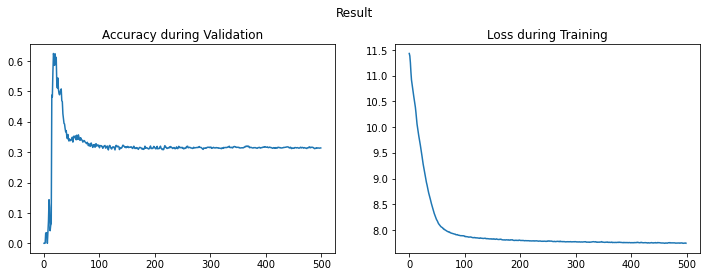

In [12]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()